In [1]:
import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
SYMBOL = "AAPL"
START_DATE = "2010-01-01"
SMA_PERIOD_SHORT = 50
SMA_PERIOD_LONG = 200
CACHE_FILE = f"{SYMBOL}_daily_yf.csv"

In [3]:
def fetch_data_yf(
    symbol, start_date, cache_file="cached_data.csv", force_refresh=False
):
    if not force_refresh and os.path.exists(cache_file):
        print(f"Loading cached data from {cache_file}")
        df = pd.read_csv(cache_file, parse_dates=["Date"], index_col="Date")
    else:
        print("Fetching data from Yahoo Finance...")
        df = yf.download(symbol, start=start_date, auto_adjust=True)

        # Change column index's to:
        df.columns = ["Close", "High", "Low", "Open", "Volume"]
        df = df.rename_axis("Date").reset_index()

        # add Adjusted Close column
        df["adjusted_close"] = df["Close"]

        # Save to CSV
        df.to_csv(cache_file, index=False)

    return df

In [4]:
def sma_crossover_strategy(df, short_period=50, long_period=200):
    df["SMA_short"] = df["adjusted_close"].rolling(window=short_period).mean()
    df["SMA_long"] = df["adjusted_close"].rolling(window=long_period).mean()

    # Generate signals: 1 (buy), -1 (sell), 0 (hold)
    df["Signal"] = 0
    df.loc[df["SMA_short"] > df["SMA_long"], "Signal"] = 1
    df.loc[df["SMA_short"] < df["SMA_long"], "Signal"] = -1

    return df


def backtest(df):
    df["Return"] = df["adjusted_close"].pct_change()
    df["Strategy"] = df["Signal"].shift(1) * df["Return"]
    df.dropna(inplace=True)

    df["Equity"] = (1 + df["Strategy"]).cumprod()
    df["BuyHold"] = (1 + df["Return"]).cumprod()

    df["Win"] = (df["Strategy"] > 0).astype(int)
    df["Loss"] = (df["Strategy"] < 0).astype(int)
    df["CumulativeWins"] = df["Win"].cumsum()
    df["CumulativeLosses"] = df["Loss"].cumsum()
    df["NetWinLoss"] = df["CumulativeWins"] - df["CumulativeLosses"]

    return df


In [5]:
df = fetch_data_yf(SYMBOL, START_DATE, CACHE_FILE)
df = sma_crossover_strategy(
    df, short_period=SMA_PERIOD_SHORT, long_period=SMA_PERIOD_LONG
)
df = backtest(df)


Loading cached data from AAPL_daily_yf.csv


## Cumulative Return: SMA 50×200 Strategy vs. Buy & Hold

This line plot shows the growth of $1 invested in either your SMA-cross strategy (Equity curve) or a simple buy-and-hold of AAPL over the same period.

- **Outperformance periods**: where the strategy curve sits above buy & hold.
- **Underperformance periods**: where it falls below.
- **Steeper slopes** correspond to periods of strong net gain; flat or negative slopes indicate little or no growth (or drawdown).


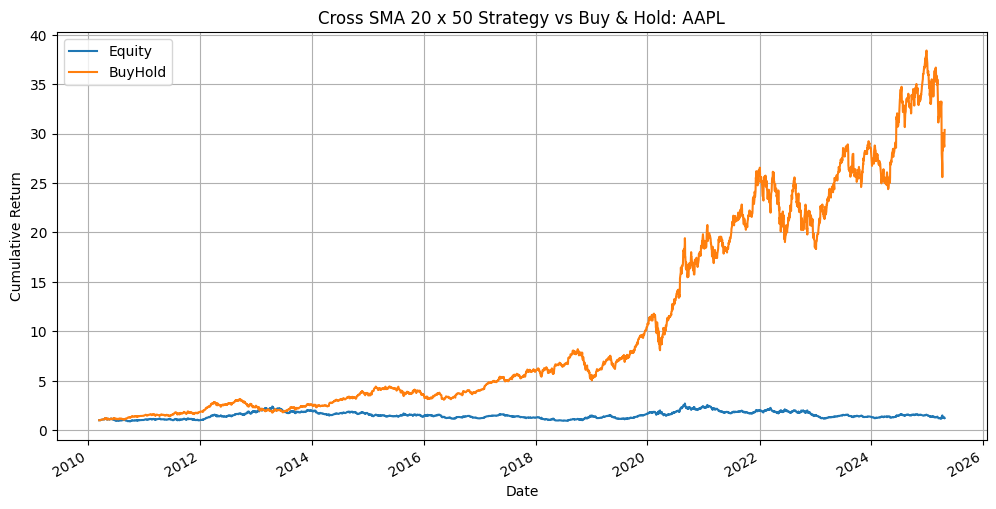

In [6]:
df[["Equity", "BuyHold"]].plot(
    figsize=(12, 6),
    title=f"Cross SMA {SMA_PERIOD_SHORT} x {SMA_PERIOD_LONG} Strategy vs Buy & Hold: {SYMBOL}",
)
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()


## Drawdown Over Time

This filled‐area chart plots, at each date, how far the strategy equity is below its historical peak (drawdown = Equity/Peak – 1).

- **Peaks (drawdown = 0)** mark all-time highs.
- **Troughs** show the worst percentage drops from peak—key measure of risk.
- **Duration of drawdowns** indicates how long the strategy stayed below its last high.


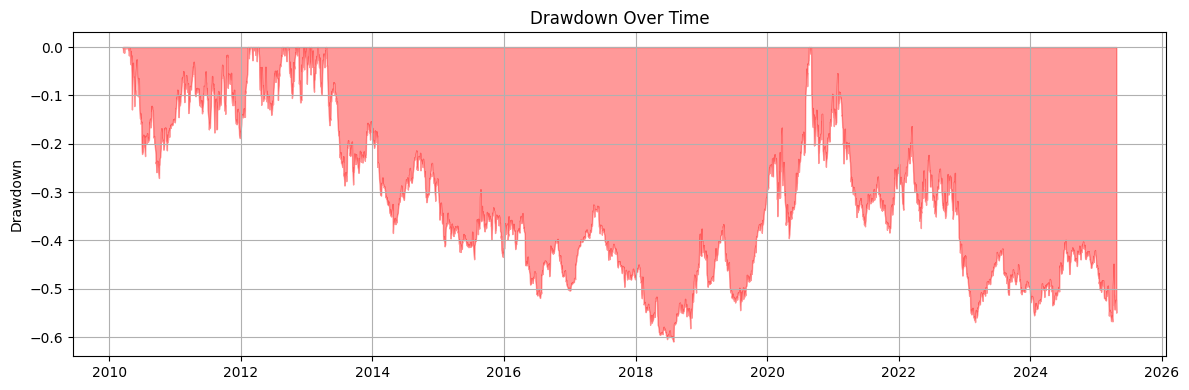

In [7]:
df["Peak"] = df["Equity"].cummax()
df["Drawdown"] = df["Equity"] / df["Peak"] - 1

plt.figure(figsize=(12, 4))
plt.fill_between(df.index, df["Drawdown"], color="red", alpha=0.4)
plt.title("Drawdown Over Time")
plt.ylabel("Drawdown")
plt.grid(True)
plt.tight_layout()
plt.show()


## Strategy Daily Returns Distribution

A histogram of your strategy’s day-to-day percentage returns:

- **Center & spread**: gives you the average daily gain (or loss) and volatility.
- **Skewness**: a long tail to the right means occasional big wins; to the left means occasional big losses.
- **Kurtosis (fat tails)** warns of extreme outliers more often than a normal distribution.


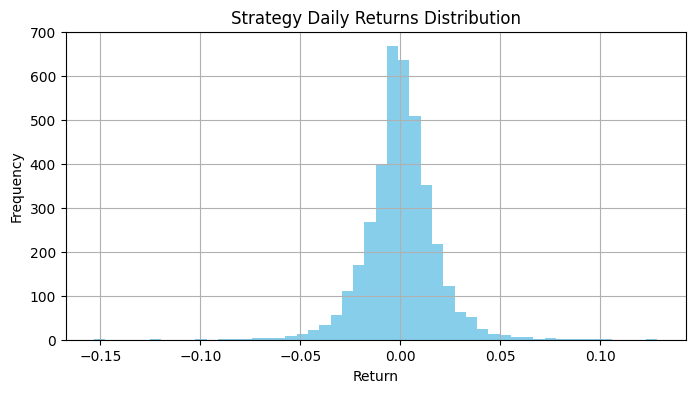

In [8]:
df["Strategy"].hist(bins=50, figsize=(8, 4), color="skyblue")
plt.title("Strategy Daily Returns Distribution")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## Distribution of Signal Holding Periods

This histogram shows the length (in bars) of every contiguous signal block—long (1), short (–1) or flat (0)—before the signal flips.

- **Flat blocks (Signal = 0)**
  - The tallest bars at “out-of-market” lengths reveal how long the strategy sits idle between trades.
  - Long flat stretches may indicate missed trends; very short flat bars mean you’re almost always in a position.
- **Long vs. Short block lengths**
  - If you split the histogram by `Signal` value, you’ll see whether long signals tend to persist longer (fat right-tail for 1) than shorts (fat tail for –1).
  - A cluster of short blocks (e.g. 1–5 bars) suggests choppy behavior—frequent flips that can rack up transaction costs.
- **Tail behavior**
  - A heavy tail (very long blocks) highlights trend-following periods where you stayed in one signal for hundreds of bars—good for capturing big moves, but also increases drawdown risk if the trend reverses.
- **Actionable insight**
  - Aim for a balance: reduce very short blocks (filter noise) while limiting excessively long blocks (cap drawdown).


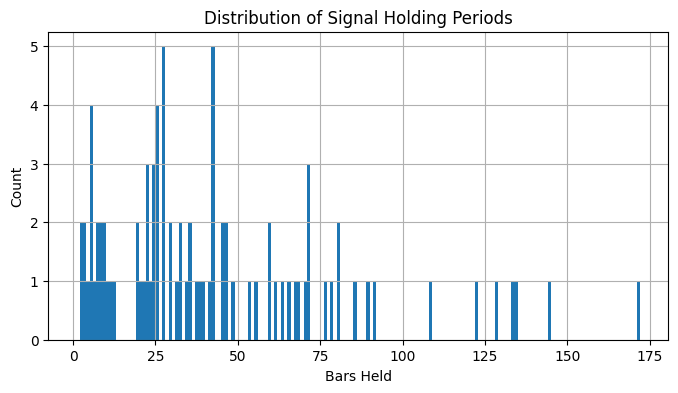

Number of signal changes: 174.0


In [9]:
df["SignalChange"] = df["Signal"].diff().fillna(0).abs()
df["SignalBlockID"] = df["SignalChange"].cumsum()

holding_periods = df.groupby("SignalBlockID").size()
holding_periods.hist(bins=range(1, holding_periods.max() + 1), figsize=(8, 4))
plt.title("Distribution of Signal Holding Periods")
plt.xlabel("Bars Held")
plt.ylabel("Count")
plt.grid(True)
plt.show()

print("Number of signal changes:", df["Signal"].diff().fillna(0).abs().sum())


## 30-Day Rolling Sharpe Ratio

A line plot of the strategy’s Sharpe ratio computed over a moving 30-day window:

- **Sharpe > 0** means returns exceeded volatility.
- **Sharpe < 0** indicates negative risk-adjusted performance.
- **Peaks and valleys** reveal when the strategy was most and least efficient.


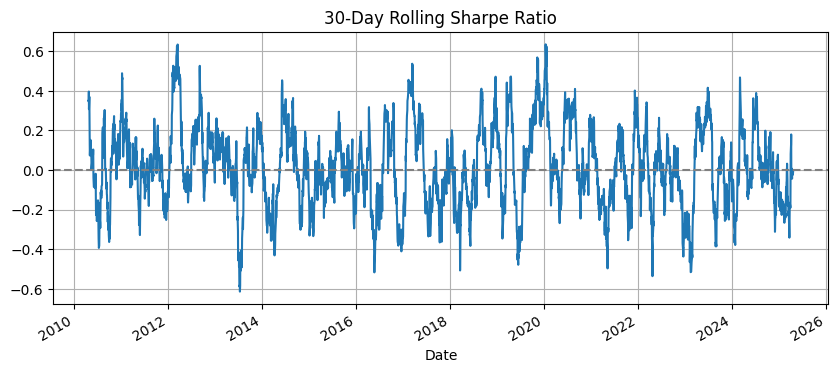

In [10]:
rolling_sharpe = (
    df["Strategy"].rolling(window=30).mean() / df["Strategy"].rolling(window=30).std()
)
plt.figure(figsize=(10, 4))
rolling_sharpe.plot()
plt.title("30-Day Rolling Sharpe Ratio")
plt.grid(True)
plt.axhline(0, color="gray", linestyle="--")
plt.show()


## Top 10 Gains vs Top 10 Losses

Two back-to-back horizontal bar charts showing the ten largest one-day gains (green) and ten largest one-day losses (red).

- **Magnitude comparison** helps you see if your best days outweigh your worst days.
- **Frequency** of large losses vs. large gains can inform whether risk-management tweaks are needed.


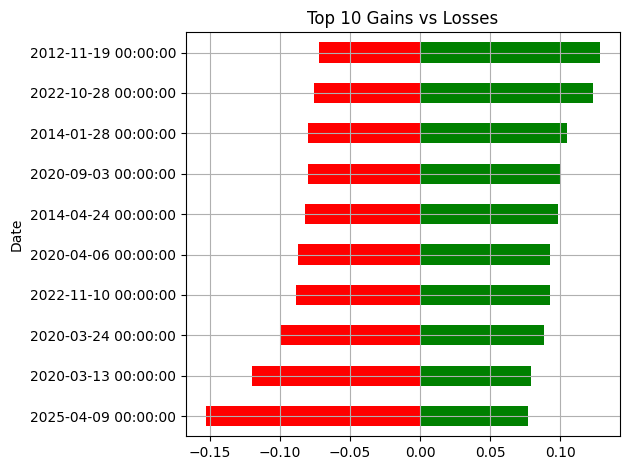

In [11]:
df["Strategy"].sort_values().tail(10).plot(kind="barh", color="green")
df["Strategy"].sort_values().head(10).plot(kind="barh", color="red")
plt.title("Top 10 Gains vs Losses")
plt.grid(True)
plt.tight_layout()
plt.show()


## Cumulative Profit Per Trade

This line chart accumulates P&L only on the days you enter or exit a position (approximate profit per completed trade).

- **Steep upward jumps** correspond to highly profitable trades.
- **Flat segments** mean trades with near-zero net.
- **Downward steps** flag losing trades.
- **Net slope** over time shows whether your edge is positive.


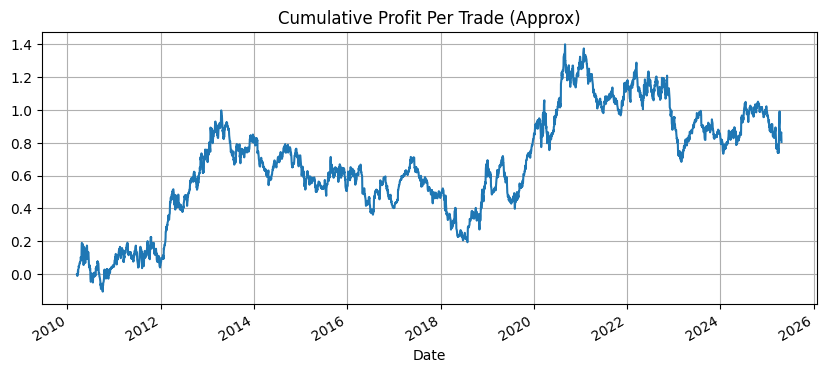

In [12]:
profits = df["Strategy"][df["Signal"].shift(1) != 0]  # only when in a position
profits.cumsum().plot(figsize=(10, 4), title="Cumulative Profit Per Trade (Approx)")
plt.grid(True)
plt.show()
